In [2]:
# importing modules

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import pickle
import joblib as jl
import os
import gc
import seaborn as sb

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.test.gpu_device_name()
tf.device('/GPU:0')

import multiprocessing
cores=multiprocessing.cpu_count()-2

import optuna
from optuna.samplers import TPESampler

2024-12-09 10:43:13.998428: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-09 10:43:16.942900: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-12-09 10:43:17.072141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-09 10:43:17.072257: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.035GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 357.69GiB/s
2024-12-09 10:43:17.072315: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-09 10:43:17.080263: I tensorflo

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [4]:
num_classes = 19 #0 - 18
np.random.seed(441) #setting seed
img_rows, img_cols = 28, 58 #image dimensions

In [5]:
# the data, split between train and test sets
def dataset(X, Y, output=100000):
    pairs_per_combination = output//100
    imgs = []
    labels = []
    l1 = []
    l2 = []
    sample_idx=0
    for i in range(10):
        for j in range(10):
            idxl1 = np.where(Y == i)[0]
            idxl2 = np.where(Y == j)[0]
            for k in range(pairs_per_combination):
                idx1 = np.random.choice(idxl1)
                idx2 = np.random.choice(idxl2)
                combined_img = np.hstack((X[idx1], X[idx2]))
                combined_label = i+j
                imgs.append(combined_img)
                labels.append(combined_label)
                l1.append(i)
                l2.append(j)
            sample_idx += 1
    shuffle_idx = np.random.permutation((len(imgs)))
    imgs = np.array(imgs)[shuffle_idx]
    labels = np.array(labels)[shuffle_idx]
    l1 = np.array(l1)[shuffle_idx]
    l2 = np.array(l2)[shuffle_idx]
    return imgs, labels, l1, l2

def jl_pairs(i, j, pairs_per_combination, X, Y):
    idxl1 = np.where(Y == i)[0]
    idxl2 = np.where(Y == j)[0]

    imgs = []
    labels = []
    l1 = []
    l2 = []
            
    for k in range(pairs_per_combination):
        idx1 = np.random.choice(idxl1)
        idx2 = np.random.choice(idxl2)
        combined_img = np.hstack((X[idx1], X[idx2]))
        combined_label = i+j
        imgs.append(combined_img)
        labels.append(combined_label)
        l1.append(i)
        l2.append(j)
    return imgs, labels, l1, l2

def jl_dataset(X, Y, output=100000, n_jobs=cores):

    pairs_per_combination = output//100
    results = jl.Parallel(n_jobs=n_jobs)(jl.delayed(jl_pairs)(i, j, pairs_per_combination, X, Y) for i in range(10) for j in range(10))
    
    imgs = []
    labels = []
    l1 = []
    l2 = []

    for ri, rl, rl1, rl2 in results:
        imgs.extend(ri)
        labels.extend(rl)
        l1.extend(rl1)
        l2.extend(rl2)

    shuffle_idx = np.random.permutation((len(imgs)))
    imgs = np.array(imgs)[shuffle_idx]
    labels = np.array(labels)[shuffle_idx]
    l1 = np.array(l1)[shuffle_idx]
    l2 = np.array(l2)[shuffle_idx]

    return imgs, labels, l1, l2

In [6]:
def load_and_score(name, number, x_test, y_test):
    model = pickle.load(open(f"{name}_model{number}.pkl", "rb"))
    predictions = pickle.load(open(f"{name}_predictions{number}.pkl", "rb"))
    score = model.score(x_test, np.argmax(y_test, axis=1))
    accuracy = accuracy_score(y_true=np.argmax(y_test, axis=1), y_pred=predictions)
    classification = classification_report(y_true=np.argmax(y_test, axis=1), y_pred=predictions)
    confusion = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=predictions)
    print(f"Score: {score}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification accuracy:\n{classification}")
    fig, ax = plt.subplots(figsize=(15, 8))
    ax = sb.heatmap(confusion, annot=True, fmt='g')
    plt.show()

In [7]:
def score_model(model, x_test, y_test, name):
    predictions = model.predict(x_test)
    score = model.score(x_test, np.argmax(y_test, axis=1))
    accuracy = accuracy_score(y_true=np.argmax(y_test, axis=1), y_pred=predictions)
    classification = classification_report(y_true=np.argmax(y_test, axis=1), y_pred=predictions)
    confusion = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=predictions)
    print(f"Score: {score}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification accuracy:\n{classification}")
    fig, ax = plt.subplots(figsize=(15, 8))
    ax = sb.heatmap(confusion, annot=True, fmt='g')
    ax.set_xlabel("Class")
    ax.set_ylabel("Class")
    ax.set_title(f"Confusion Matrix for {name}", fontsize=20)
    plt.savefig(f"confusion_{name}.png")
    plt.show()

In [8]:
def get_data(output=100000, train_ratio=0.8, split=False):
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    X_in = np.concatenate([x_train, x_test])
    Y_in = np.concatenate([y_train, y_test])

    X_in = X_in.astype('float32')
    X_in /= 255

    X, Y = jl_dataset(X_in, Y_in, output=output)[:2]

    X = X.reshape(X.shape[0], -1)

    if split:
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-train_ratio), random_state=441)
        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)
        
        return x_train, y_train, x_test, y_test
    else:
        Y = to_categorical(Y, num_classes)
        return X, Y

    

# SVM

In [9]:
X, Y = get_data(output=10000)

def objective(trial):
    gamma = trial.suggest_float('gamma', 0.01, 6000, log=True)
    c = trial.suggest_float('c', 0.01, 1000, log=True)
    # kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid'])
    degree = trial.suggest_int('degree',3, 6)

    svm = SVC(
        kernel='poly', 
        gamma=gamma, 
        C=c, 
        degree=degree,
        decision_function_shape='ovr',
        random_state=441
          )
    
    cv = StratifiedKFold(n_splits=5, random_state=441, shuffle=True)
    score = cross_val_score(svm, X, np.argmax(Y, axis=1), cv=cv, scoring='accuracy')
    return np.mean(score)

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=20, show_progress_bar=True)

with open("best_svm_model2.pkl", "wb") as f:
    pickle.dump(study, f)

[I 2024-12-07 09:38:42,608] A new study created in memory with name: no-name-4f609805-d5f8-4b28-903a-d9ed5e1b4e32


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-12-07 09:44:50,870] Trial 0 finished with value: 0.4788 and parameters: {'gamma': 0.07630314511335011, 'c': 24.501357604314933, 'degree': 6}. Best is trial 0 with value: 0.4788.
[I 2024-12-07 09:49:11,670] Trial 1 finished with value: 0.5471999999999999 and parameters: {'gamma': 1683.7244545235424, 'c': 12.40254503273663, 'degree': 5}. Best is trial 1 with value: 0.5471999999999999.
[I 2024-12-07 09:53:14,206] Trial 2 finished with value: 0.5811999999999999 and parameters: {'gamma': 428.9954463398429, 'c': 1.6109184749452046, 'degree': 4}. Best is trial 2 with value: 0.5811999999999999.
[I 2024-12-07 09:57:08,129] Trial 3 finished with value: 0.5811999999999999 and parameters: {'gamma': 1591.8603458186744, 'c': 0.1762759238053958, 'degree': 4}. Best is trial 2 with value: 0.5811999999999999.
[I 2024-12-07 10:01:25,394] Trial 4 finished with value: 0.4787 and parameters: {'gamma': 1.4609773955205585, 'c': 0.5715593995240277, 'degree': 6}. Best is trial 2 with value: 0.5811999999

In [13]:
with open("best_svm_model2.pkl", "rb") as f:
    svm_study = pickle.load(f)
    
print('Best trial:')
print(f' Value: {svm_study.best_trial.value}')
print(' Params: ')
for key, value in svm_study.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
 Value: 0.6
 Params: 
    gamma: 21.768741718394928
    c: 1.6140097971440113
    degree: 3


In [14]:
x_train, y_train, x_test, y_test = get_data(output=80000, split=True)

svm = SVC(
        kernel='poly', 
        gamma=svm_study.best_trial.params['gamma'], 
        C=svm_study.best_trial.params['c'], 
        degree=svm_study.best_trial.params['degree'],
        decision_function_shape='ovr',
        random_state=441
          )

svm_clf = svm.fit(x_train, np.argmax(y_train, axis=1))

with open("svm_fitted_model2.pkl", "wb") as f:
    pickle.dump(svm_clf, f)

Score: 0.8159
Accuracy: 0.8159
Classification accuracy:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       800
           1       0.90      0.96      0.93      1600
           2       0.89      0.90      0.89      2400
           3       0.86      0.87      0.86      3200
           4       0.85      0.87      0.86      4000
           5       0.83      0.84      0.84      4800
           6       0.82      0.83      0.83      5600
           7       0.82      0.83      0.82      6400
           8       0.80      0.81      0.81      7200
           9       0.79      0.81      0.80      8000
          10       0.78      0.78      0.78      7200
          11       0.77      0.78      0.77      6400
          12       0.79      0.79      0.79      5600
          13       0.82      0.79      0.81      4800
          14       0.83      0.78      0.81      4000
          15       0.85      0.81      0.83      3200
          16       0.84  

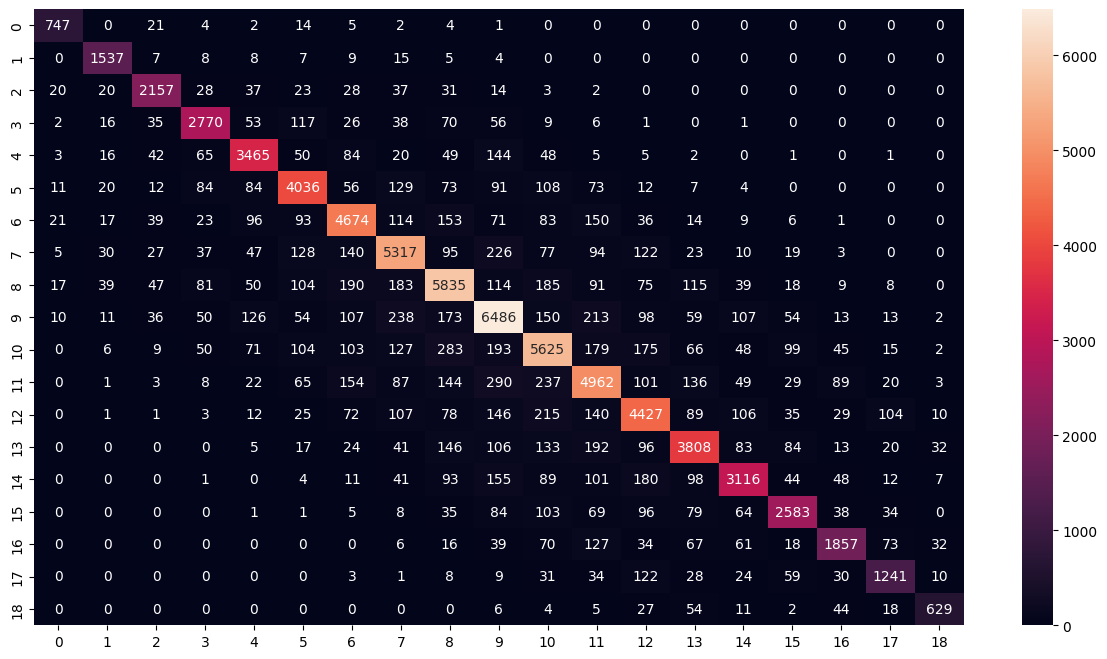

In [22]:
with open("svm_fitted_model2.pkl", "rb") as f:
    svm_clf = pickle.load(f)

score_model(svm_clf, x_test, y_test)

# Random Forest

In [9]:
x_train, y_train, x_test, y_test = get_data(output=100000, train_ratio=0.8, split=True)

def forest_objective(trial):
    depth = trial.suggest_int('depth', 500, 1000)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    forest = RandomForestClassifier(max_depth=depth, n_jobs=cores, n_estimators=n_estimators, criterion=criterion, max_features=max_features)
    forest.fit(x_train, np.argmax(y_train, axis=1))
    score = forest.score(x_test, np.argmax(y_test, axis=1))
    
    return score

forest_study = optuna.create_study(direction='maximize')

forest_study.optimize(forest_objective, n_trials=50, show_progress_bar=True)

[I 2024-12-08 16:46:30,350] A new study created in memory with name: no-name-0af8f24b-042a-4fc9-a52c-0fb57ae3c046


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-12-08 16:46:34,490] Trial 0 finished with value: 0.7021 and parameters: {'depth': 865, 'n_estimators': 76, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 0 with value: 0.7021.
[I 2024-12-08 16:46:55,762] Trial 1 finished with value: 0.77275 and parameters: {'depth': 895, 'n_estimators': 95, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 1 with value: 0.77275.
[I 2024-12-08 16:47:33,973] Trial 2 finished with value: 0.7927 and parameters: {'depth': 686, 'n_estimators': 196, 'criterion': 'log_loss', 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7927.
[I 2024-12-08 16:48:07,379] Trial 3 finished with value: 0.7898 and parameters: {'depth': 801, 'n_estimators': 163, 'criterion': 'log_loss', 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7927.
[I 2024-12-08 16:48:16,803] Trial 4 finished with value: 0.7424 and parameters: {'depth': 955, 'n_estimators': 145, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 2 with value: 0.79

In [11]:
with open("best_forest_model.pkl", "wb") as f:
    pickle.dump(forest_study, f)

In [12]:
with open("best_forest_model.pkl", "rb") as f:
    forest_study = pickle.load(f)

print('Best trial:')
print(f' Value: {forest_study.best_trial.value}')
print(' Params: ')
for key, value in forest_study.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
 Value: 0.796
 Params: 
    depth: 503
    n_estimators: 188
    criterion: gini
    max_features: sqrt


Score: 0.7937
Accuracy: 0.7937
Classification accuracy:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       188
           1       0.92      0.93      0.92       392
           2       0.89      0.88      0.88       586
           3       0.86      0.84      0.85       857
           4       0.87      0.83      0.85      1014
           5       0.84      0.81      0.83      1251
           6       0.83      0.84      0.84      1400
           7       0.83      0.80      0.82      1639
           8       0.76      0.84      0.80      1738
           9       0.72      0.84      0.78      1941
          10       0.74      0.78      0.76      1778
          11       0.74      0.77      0.76      1590
          12       0.72      0.79      0.75      1379
          13       0.75      0.76      0.76      1177
          14       0.83      0.65      0.73      1011
          15       0.87      0.73      0.79       834
          16       0.82  

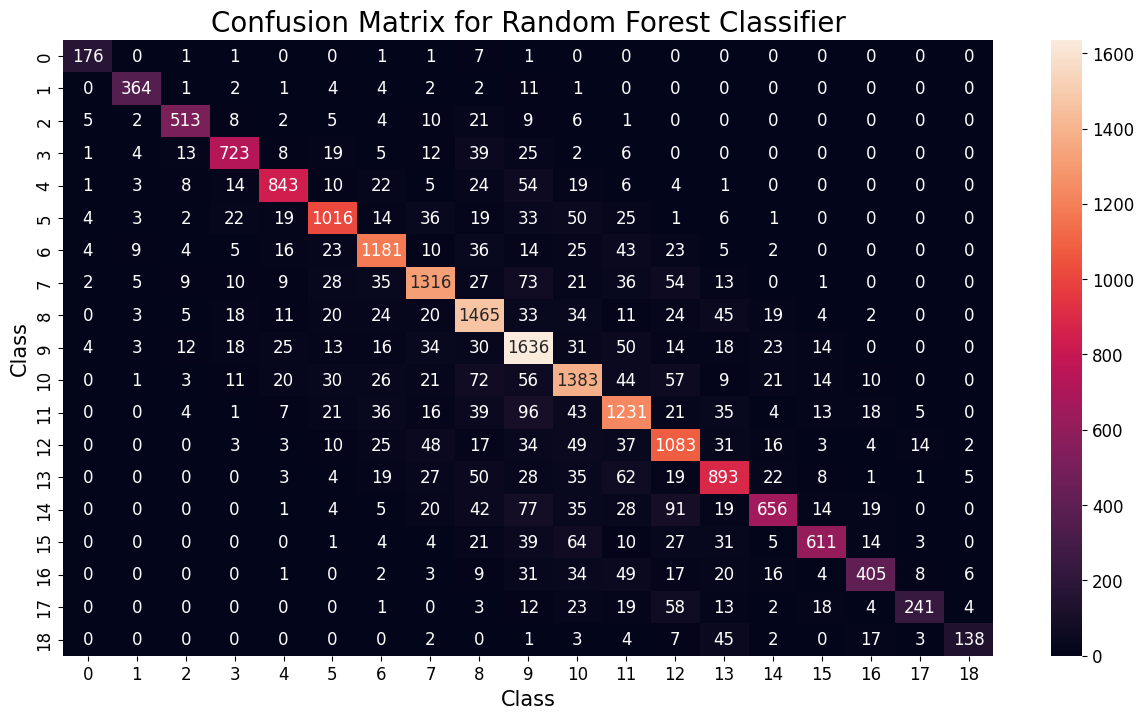

: 

In [13]:
forest = RandomForestClassifier(max_depth=forest_study.best_trial.params['depth'], 
                                n_jobs=cores, 
                                n_estimators=forest_study.best_trial.params['n_estimators'], 
                                criterion=forest_study.best_trial.params['criterion'], 
                                max_features=forest_study.best_trial.params['max_features'])

forest.fit(x_train, np.argmax(y_train, axis=1))
score_model(forest, x_test, y_test, "Random Forest Classifier")

# Adaboost

In [13]:
x_train, y_train, x_test, y_test = get_data(output=100000, train_ratio=0.8, split=True)

def adaboost_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    estimator = trial.suggest_categorical('estimator', ['DecisionTreeClassifier', ''])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)

    adaboost = AdaBoostClassifier(n_estimators=n_estimators)
    adaboost.fit(x_train, np.argmax(y_train, axis=1))
    score = adaboost.score(x_test, np.argmax(y_test, axis=1))
    
    return score

adaboost_study = optuna.create_study(direction='maximize')

adaboost_study.optimize(adaboost_objective, n_trials=5, show_progress_bar=True)

with open("best_adaboost_model.pkl", "wb") as f:
    pickle.dump(adaboost_study, f)

[I 2024-12-09 11:44:29,925] A new study created in memory with name: no-name-384281e1-6b9c-4561-b25e-472fa641ef6f


  0%|          | 0/5 [00:00<?, ?it/s]

/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-09 11:49:46,458] Trial 0 finished with value: 0.1392 and parameters: {'n_estimators': 82}. Best is trial 0 with value: 0.1392.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-09 11:54:32,785] Trial 1 finished with value: 0.13885 and parameters: {'n_estimators': 74}. Best is trial 0 with value: 0.1392.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-09 11:56:31,700] Trial 2 finished with value: 0.13865 and parameters: {'n_estimators': 31}. Best is trial 0 with value: 0.1392.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-09 12:00:56,445] Trial 3 finished with value: 0.14045 and parameters: {'n_estimators': 68}. Best is trial 3 with value: 0.14045.


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-12-09 12:02:09,940] Trial 4 finished with value: 0.13205 and parameters: {'n_estimators': 19}. Best is trial 3 with value: 0.14045.


In [15]:
with open("best_adaboost_model.pkl", "rb") as f:
    adaboost_study = pickle.load(f)

print('Best trial:')
print(f' Value: {adaboost_study.best_trial.value}')
print(' Params: ')
for key, value in adaboost_study.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
 Value: 0.14045
 Params: 
    n_estimators: 68


/home/ljf1/dis/tf/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Score: 0.14045
Accuracy: 0.14045
Classification accuracy:
              precision    recall  f1-score   support

           0       0.35      0.79      0.48       199
           1       0.18      0.25      0.21       407
           2       0.17      0.27      0.21       591
           3       0.15      0.13      0.14       816
           4       0.15      0.07      0.10       969
           5       0.07      0.05      0.06      1192
           6       0.13      0.18      0.15      1412
           7       0.19      0.11      0.14      1603
           8       0.11      0.07      0.09      1782
           9       0.19      0.19      0.19      2071
          10       0.13      0.24      0.17      1848
          11       0.12      0.08      0.10      1591
          12       0.11      0.14      0.13      1378
          13       0.08      0.03      0.04      1177
          14       0.12      0.03      0.05      1003
          15       0.13      0.22      0.17       808
          16       0.05

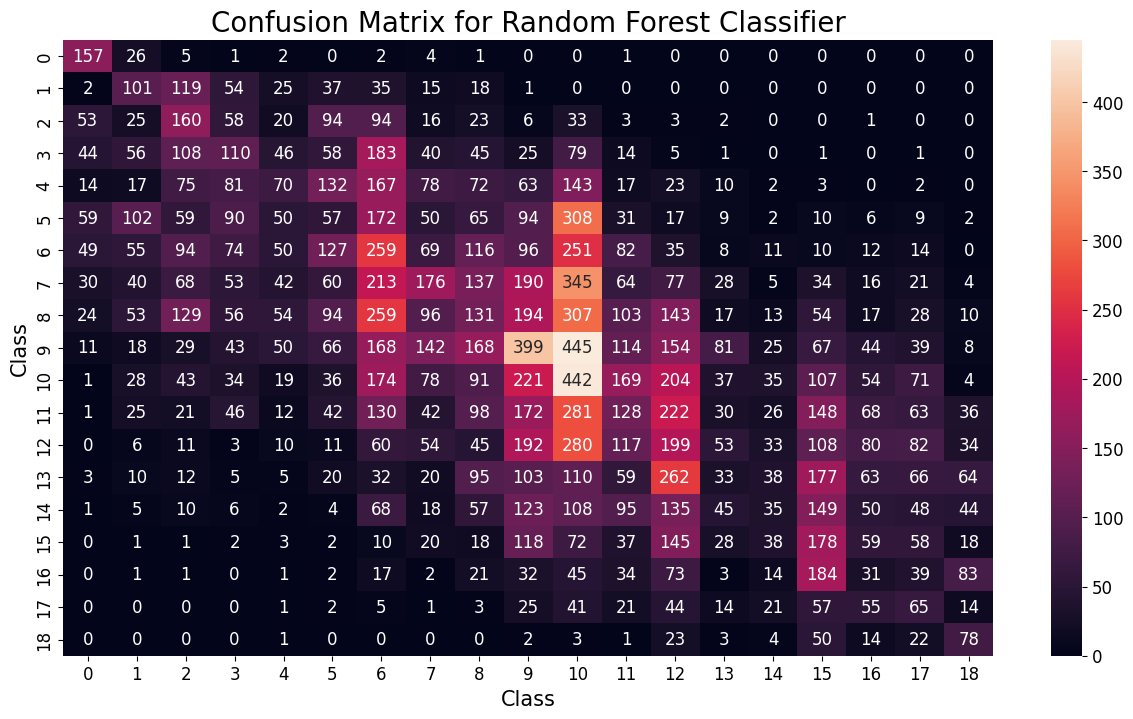

: 

In [18]:
adaboost = AdaBoostClassifier(n_estimators=adaboost_study.best_trial.params['n_estimators'], 
                            #   learning_rate=adaboost_study.best_trial.params['learning_rate']
                              )

adaboost.fit(x_train, np.argmax(y_train, axis=1))
score_model(adaboost, x_test, y_test, "Random Forest Classifier")